In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

def display_spectrogram(audio_array: np.ndarray):
  plt.specgram(audio_array, NFFT=400, Fs=SAMPLE_RATE)
  plt.show()

In [3]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000
SHIFT = 10

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [4]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.num_mels = 64
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    self.ms = MelSpectrogram(SAMPLE_RATE, n_mels=self.num_mels)
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        waveform, sample_rate = torchaudio.load(f"./data/bark/{folder_name}/{fn}")
        self.voices[-1].append(waveform.view(-1, 1))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices) * self.k)
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(self.ms(t[r:r + self.embedding_dim].view(1, -1)).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(self.ms(s[r:r + self.embedding_dim].view(1, -1)).numpy())
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, self.num_mels, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [5]:
dataset = VoiceDataset("./data/bark")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [6]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

In [12]:
class Judge(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq1 = nn.Sequential(
      nn.Conv2d(1, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(4),
      nn.ReLU(True),
      nn.Conv2d(64, 128, 2),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.ReLU(True),
      nn.Conv2d(128, 256, 2),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(2),
      nn.ReLU(True)
    )
    self.gru = nn.GRU(256, 256, 2, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 40, 256),
      nn.ReLU(True),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs2 = self.seq1(target.view(sample.size(0), 1, sample.size(1), sample.size(2)))
    outputs1, _ = self.gru(outputs1.squeeze(2).permute(0, 2, 1))
    outputs2, _ = self.gru(outputs2.squeeze(2).permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    return outputs

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.judge = Judge()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [8]:
samples, targets, labels = next(iter(dataloader))
model = Model()
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 64, 361]) torch.Size([4, 10, 64, 361])
tensor([[0.0999, 0.0998, 0.0996, 0.1000, 0.1001, 0.1000, 0.1001, 0.1004, 0.1001,
         0.1000],
        [0.1000, 0.1002, 0.0998, 0.0999, 0.1002, 0.1000, 0.1001, 0.1002, 0.0997,
         0.0998],
        [0.0998, 0.0993, 0.1004, 0.1003, 0.0999, 0.1001, 0.1003, 0.1000, 0.0998,
         0.1001],
        [0.0998, 0.0998, 0.1001, 0.0999, 0.1003, 0.1002, 0.0998, 0.0999, 0.1002,
         0.1001]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(2.3026, grad_fn=<DivBackward1>)


100/10000:	2.3025
200/10000:	2.3022
300/10000:	2.3023
400/10000:	2.3004
500/10000:	2.2955
600/10000:	2.2900
700/10000:	2.2825
800/10000:	2.2758
900/10000:	2.2752
1000/10000:	2.2725
1100/10000:	2.2673
1200/10000:	2.2703
1300/10000:	2.2679
1400/10000:	2.2674
1500/10000:	2.2621
1600/10000:	2.2606
1700/10000:	2.2592
1800/10000:	2.2565
1900/10000:	2.2569
2000/10000:	2.2491
2100/10000:	2.2513
2200/10000:	2.2449
2300/10000:	2.2443
2400/10000:	2.2438
2500/10000:	2.2414
2600/10000:	2.2349
2700/10000:	2.2381
2800/10000:	2.2382
2900/10000:	2.2390
3000/10000:	2.2368
3100/10000:	2.2349
3200/10000:	2.2340
3300/10000:	2.2326
3400/10000:	2.2339
3500/10000:	2.2346
3600/10000:	2.2324
3700/10000:	2.2270
3800/10000:	2.2267
3900/10000:	2.2306
4000/10000:	2.2278
4100/10000:	2.2271
4200/10000:	2.2296
4300/10000:	2.2270
4400/10000:	2.2252
4500/10000:	2.2280
4600/10000:	2.2273
4700/10000:	2.2262
4800/10000:	2.2244
4900/10000:	2.2255
5000/10000:	2.2240
5100/10000:	2.2250
5200/10000:	2.2247
5300/10000:	2.2225
54

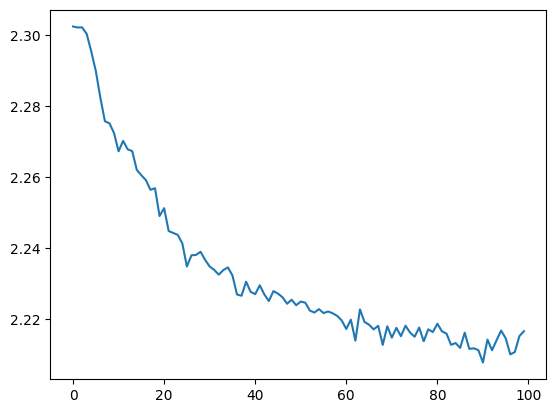

In [13]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Kui\AppData\Local\Temp\ipykernel_40812\696373266.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(self.ms(torch.tensor(target[r:r + self.embedding_dim].view(1, -1)).float()).numpy())


array([[0.17864394, 0.07444522, 0.07541084, 0.13404033, 0.16381109,
        0.07644427, 0.07430102, 0.07430126, 0.07430101, 0.07430101]])

array([493.,   0.,   1., 134., 372.,   0.,   0.,   0.,   0.,   0.])

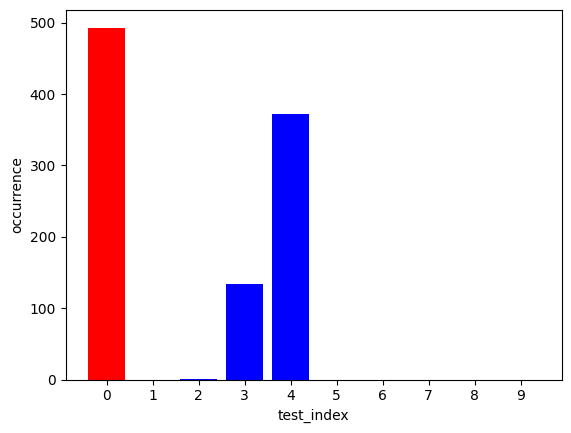

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07865883, 0.19694354, 0.19538686, 0.07478944, 0.08034432,
        0.0747754 , 0.0747754 , 0.0747754 , 0.0747754 , 0.0747754 ]])

array([  1., 535., 463.,   0.,   1.,   0.,   0.,   0.,   0.,   0.])

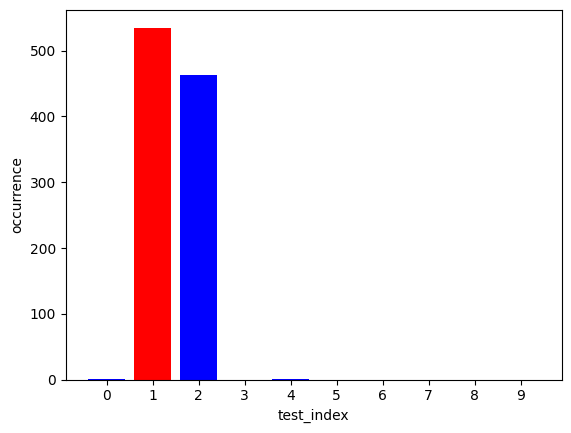

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07582133, 0.20136363, 0.19793656, 0.07470926, 0.07662323,
        0.0747092 , 0.0747092 , 0.0747092 , 0.0747092 , 0.0747092 ]])

array([  1., 546., 453.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

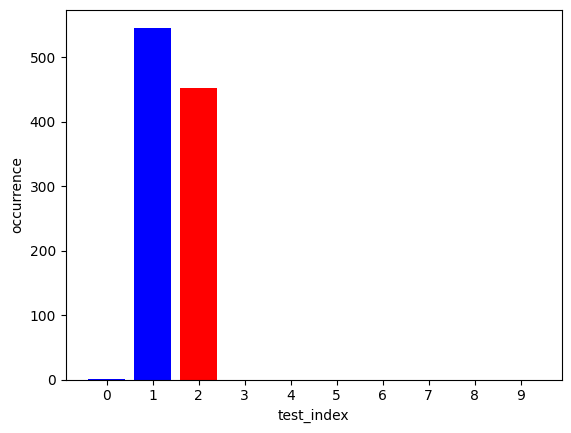

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.17315589, 0.07538061, 0.0760471 , 0.15641811, 0.1399754 ,
        0.07750762, 0.07537828, 0.07538043, 0.07537828, 0.07537828]])

array([525.,   0.,   2., 271., 200.,   2.,   0.,   0.,   0.,   0.])

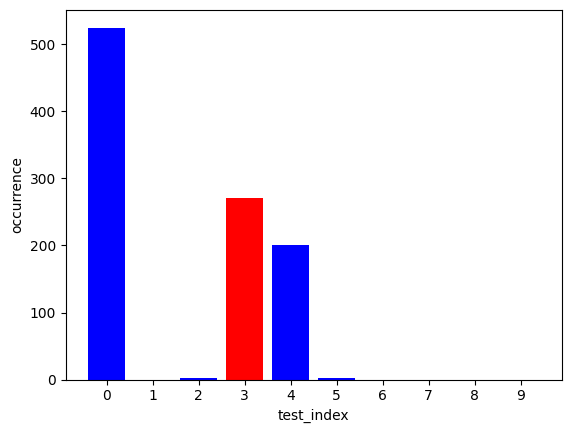

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.15858379, 0.08307544, 0.08723031, 0.07947677, 0.20188096,
        0.07795156, 0.07795029, 0.07795029, 0.07795029, 0.07795029]])

array([241.,   6.,  11.,   0., 742.,   0.,   0.,   0.,   0.,   0.])

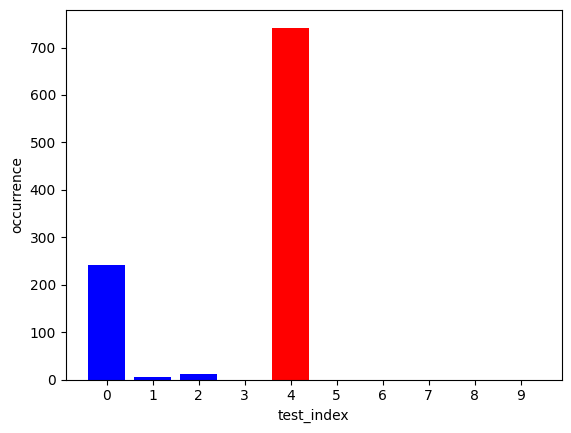

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.09248933, 0.07726933, 0.07764291, 0.15165884, 0.0786652 ,
        0.1941333 , 0.07832213, 0.09528029, 0.07726933, 0.07726933]])

array([ 28.,   0.,   1., 255.,   3., 691.,   0.,  22.,   0.,   0.])

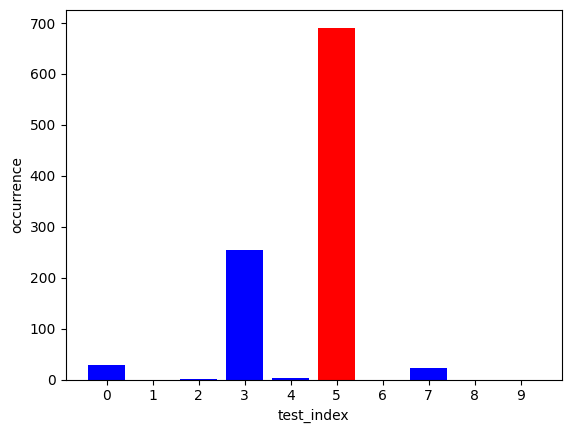

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07839478, 0.07543986, 0.07564754, 0.07759097, 0.07570082,
        0.08741541, 0.18116373, 0.16417554, 0.0958811 , 0.08859027]])

array([  4.,   0.,   1.,   0.,   0.,  20., 628., 294.,  40.,  13.])

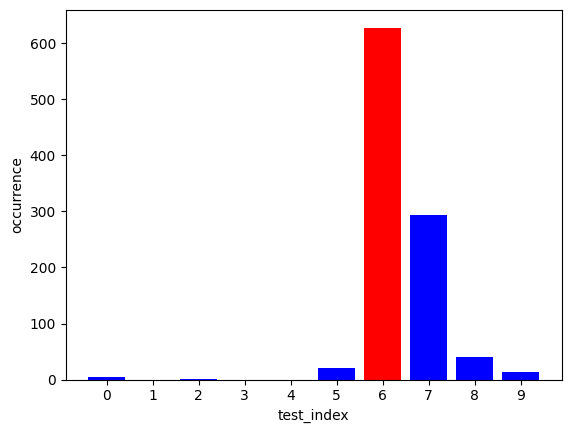

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07838204, 0.0759101 , 0.07619631, 0.07950006, 0.07695539,
        0.12911492, 0.13721367, 0.19416284, 0.07665343, 0.07591125]])

array([  5.,   0.,   0.,   4.,   5.,  92., 144., 750.,   0.,   0.])

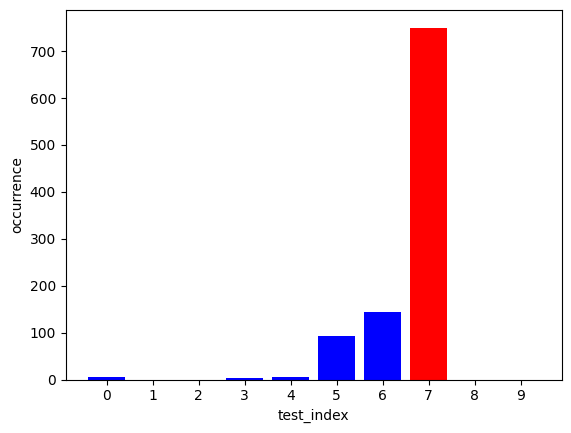

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07296274, 0.07245258, 0.07402022, 0.07245258, 0.07289277,
        0.07348729, 0.11327313, 0.0761826 , 0.18536056, 0.18691554]])

array([  2.,   0.,   7.,   0.,   2.,   5.,  70.,   2., 424., 488.])

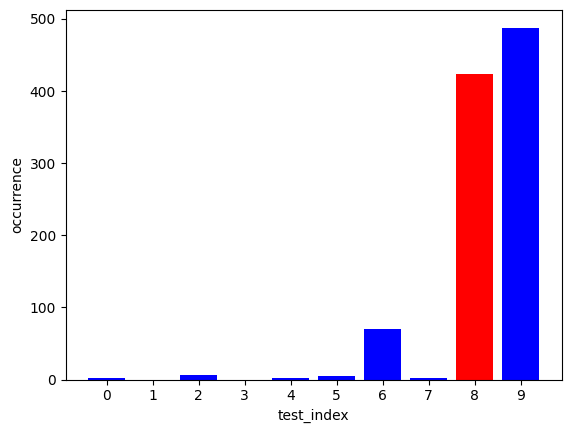

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07641916, 0.07478362, 0.07523499, 0.07487701, 0.07545513,
        0.07788595, 0.17816551, 0.12513506, 0.12664397, 0.1153996 ]])

array([  5.,   0.,   0.,   0.,   2.,   4., 583., 144., 152., 110.])

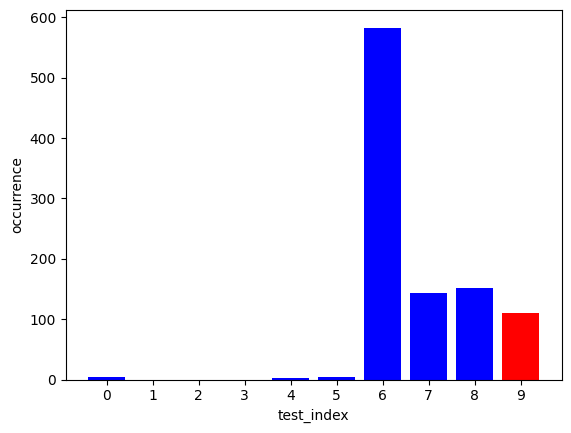

In [14]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t, _ = torchaudio.load(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t.view(-1, 1))
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [8]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
preload_models(use_smaller_models=True)

In [9]:
raw_prompts = [
  "A pessimist is one who makes difficulties of his opportunities and an optimist is one who makes opportunities of his difficulties.",
  "Don't judge each day by the harvest you reap but by the seeds that you plant.",
  "Challenges are what make life interesting and overcoming them is what makes life meaningful.",
  "Happiness lies not in the mere possession of money; it lies in the joy of achievement, in the thrill of creative effort.",
  "I disapprove of what you say, but I will defend to the death your right to say it.",
  "If I looked compared to others far, is because I stand on giant's shoulder.",
  "Never argue with stupid people, they will drag you down to their level and then beat you with experience.",
  "The greatest glory in living lies not in never falling, but in rising every time we fall.",
  "When you look into the abyss, the abyss also looks into you.",
  "Whoever fights monsters should see to it that in the process he does not become a monster."
]

basename = "woman-2"

for i, raw_prompt in enumerate(raw_prompts):
  generate(basename, raw_prompt, i)

woman-2: prompt-0
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.02it/s]


woman-2: prompt-1
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


woman-2: prompt-2
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 26/26 [00:25<00:00,  1.00it/s]


woman-2: prompt-3
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


woman-2: prompt-4
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


woman-2: prompt-5
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


woman-2: prompt-6
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


woman-2: prompt-7
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


woman-2: prompt-8
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


woman-2: prompt-9
history_prompt in gen: woman-2
woman-2
aa


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
